In [2]:
import sys
import os


import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.preprocessing import RobustScaler,StandardScaler, MinMaxScaler
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering, SpectralClustering
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
import importlib
from sklearn.decomposition import PCA

path_src = os.path.abspath('../../../src')

# Agregar esa ruta al sys.path si no está ya
if path_src not in sys.path:
    sys.path.append(path_src)

# Importar utils normalmente
import utils
importlib.reload(utils)

# Importar funciones específicas
from utils import (
    kmeans_clustering_mlflow,
    transform_pca,
    silhouette_analysis,
    elbow_method,
    plot_davies_bouldin_scores,
    evaluar_calinski_harabasz
)

In [7]:

ecommerce_data = pd.read_csv('../../../dataset/online_retail_clean.csv')

ecommerce_data.head()

,id_factura,id_producto,descripcion,cantidad,precio_unitario,id_cliente,pais,monto,dia,mes,anio,horario
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2.55,17850.0,United Kingdom,15.30,1,12,2010,08:26:00
1,536365,71053,WHITE METAL LANTERN,6,3.39,17850.0,United Kingdom,20.34,1,12,2010,08:26:00
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2.75,17850.0,United Kingdom,22.00,1,12,2010,08:26:00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,3.39,17850.0,United Kingdom,20.34,1,12,2010,08:26:00
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,3.39,17850.0,United Kingdom,20.34,1,12,2010,08:26:00


In [8]:
ecommerce_data_uk = ecommerce_data[ecommerce_data['pais'] == 'United Kingdom']



ecommerce_data_uk = ecommerce_data_uk[~ecommerce_data_uk['id_producto'].isin(['PADS', 'DOT', 'M','C2', 'POST', 'BANK CHARGES'])]
ecommerce_data_uk.head()



,id_factura,id_producto,descripcion,cantidad,precio_unitario,id_cliente,pais,monto,dia,mes,anio,horario
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2.55,17850.0,United Kingdom,15.30,1,12,2010,08:26:00
1,536365,71053,WHITE METAL LANTERN,6,3.39,17850.0,United Kingdom,20.34,1,12,2010,08:26:00
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2.75,17850.0,United Kingdom,22.00,1,12,2010,08:26:00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,3.39,17850.0,United Kingdom,20.34,1,12,2010,08:26:00
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,3.39,17850.0,United Kingdom,20.34,1,12,2010,08:26:00


In [9]:
productos_clusters=pd.read_csv('../../../dataset/k_means_productos_locales.csv')

productos_clusters.head()



,id_producto,Cluster
0,10080,0
1,10120,0
2,10124A,2
3,10124G,2
4,10125,0


In [10]:
clientes_clusters=pd.read_csv('../../../dataset/k_means_clientes_locales.csv')

clientes_clusters.head()


,id_cliente,Cluster
0,12820.0,0
1,12821.0,1
2,12822.0,0
3,12823.0,2
4,12824.0,0


In [11]:
clientes_clusters = clientes_clusters.rename(columns={'Cluster': 'cluster_cliente'})
productos_clusters = productos_clusters.rename(columns={'Cluster': 'cluster_producto'})

# Hacer merge de ecommerce_data_uk con clientes_clusters
df_merged = ecommerce_data_uk.merge(clientes_clusters, on='id_cliente', how='left')

# Luego merge con productos_clusters
df_merged = df_merged.merge(productos_clusters, on='id_producto', how='left')

# Eliminar filas donde no se encontró cluster de cliente o producto
df_merged = df_merged.dropna(subset=['cluster_cliente', 'cluster_producto'])

# (Opcional) Resetear el índice
df_merged = df_merged.reset_index(drop=True)

# Mostrar resultado
df_merged.head(10)


,id_factura,id_producto,descripcion,cantidad,precio_unitario,id_cliente,pais,monto,dia,mes,anio,horario,cluster_cliente,cluster_producto
0,536382,21832,CHOCOLATE CALCULATOR,12,1.65,16098.0,United Kingdom,19.80,1,12,2010,09:45:00,2.0,0.0
1,536382,22839,3 TIER CAKE TIN GREEN AND CREAM,2,14.95,16098.0,United Kingdom,29.90,1,12,2010,09:45:00,2.0,1.0
2,536382,22838,3 TIER CAKE TIN RED AND CREAM,2,14.95,16098.0,United Kingdom,29.90,1,12,2010,09:45:00,2.0,1.0
3,536385,85049A,TRADITIONAL CHRISTMAS RIBBONS,12,1.25,17420.0,United Kingdom,15.00,1,12,2010,09:56:00,0.0,1.0
4,536388,21363,HOME SMALL WOOD LETTERS,3,4.95,16250.0,United Kingdom,14.85,1,12,2010,09:59:00,1.0,2.0
5,536388,21411,GINGHAM HEART DOORSTOP RED,3,4.25,16250.0,United Kingdom,12.75,1,12,2010,09:59:00,1.0,1.0
6,536388,22318,FIVE HEART HANGING DECORATION,6,2.95,16250.0,United Kingdom,17.70,1,12,2010,09:59:00,1.0,0.0
7,536388,22915,ASSORTED BOTTLE TOP MAGNETS,12,0.42,16250.0,United Kingdom,5.04,1,12,2010,09:59:00,1.0,1.0
8,536388,22922,FRIDGE MAGNETS US DINER ASSORTED,12,0.85,16250.0,United Kingdom,10.20,1,12,2010,09:59:00,1.0,0.0
9,536388,22923,FRIDGE MAGNETS LES ENFANTS ASSORTED,12,0.85,16250.0,United Kingdom,10.20,1,12,2010,09:59:00,1.0,0.0


### tabla de contigencia

In [12]:
tabla_conexiones = pd.crosstab(df_merged['cluster_cliente'], df_merged['cluster_producto'])

tabla_conexiones

cluster_producto,0.0,1.0,2.0
cluster_cliente,,,
0.0,14726,18996,1260
1.0,4096,4807,699
2.0,16709,22777,1930


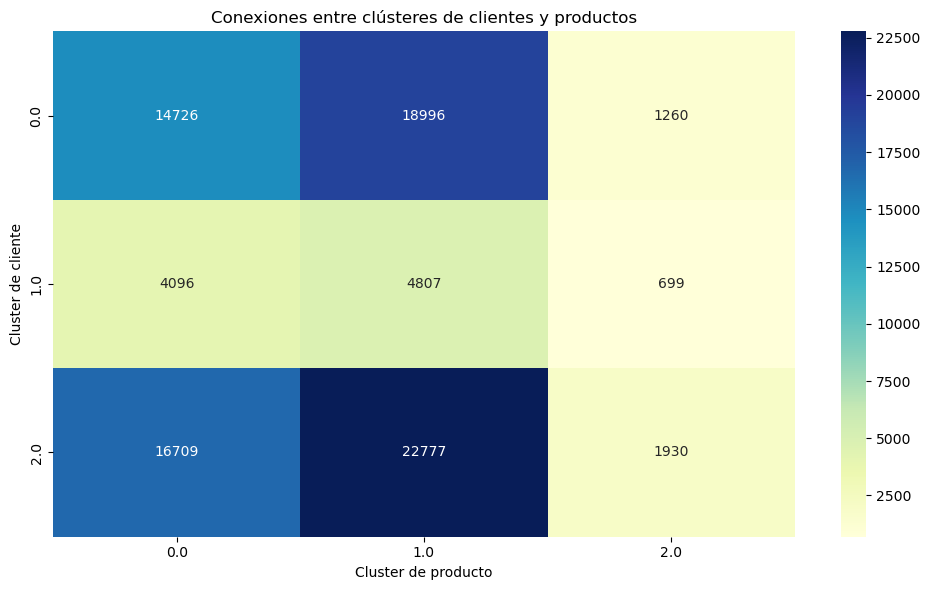

In [13]:
plt.figure(figsize=(10, 6))
sns.heatmap(tabla_conexiones, annot=True, fmt='d', cmap='YlGnBu')

plt.title("Conexiones entre clústeres de clientes y productos")
plt.xlabel("Cluster de producto")
plt.ylabel("Cluster de cliente")
plt.tight_layout()
plt.show()


### gasto de los clusteres de cliente en cada cluster de producto 

In [14]:
# Agrupar por clúster de cliente y producto, y sumar el monto total
conexiones_monto = df_merged.groupby(['cluster_cliente', 'cluster_producto'])['monto'].sum().unstack(fill_value=0)

# Mostrar la tabla
print(conexiones_monto)


cluster_producto        0.0        1.0       2.0
cluster_cliente                                 
0.0               138289.50  186335.30  11716.48
1.0                48584.43   57754.58   9437.74
2.0               181052.38  262571.99  22869.87


/tmp/ipykernel_14189/339071380.py:10: UserWarning: Glyph 128176 (\N{MONEY BAG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/home/agustin/miniconda3/envs/ecommerce/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128176 (\N{MONEY BAG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


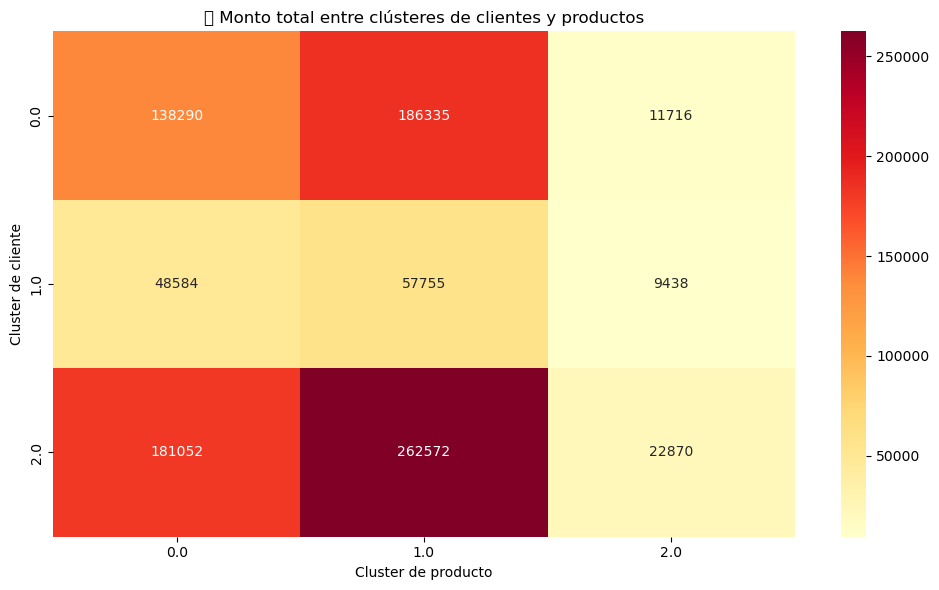

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.heatmap(conexiones_monto, annot=True, fmt='.0f', cmap='YlOrRd')

plt.title("💰 Monto total entre clústeres de clientes y productos")
plt.xlabel("Cluster de producto")
plt.ylabel("Cluster de cliente")
plt.tight_layout()
plt.show()


### cantidad de cada unidades que se llevan de cada cluster de productos por cada cluster de cliente

In [16]:
# Agrupar por clúster de cliente y producto, y sumar la cantidad total
conexiones_cantidad = df_merged.groupby(['cluster_cliente', 'cluster_producto'])['cantidad'].sum().unstack(fill_value=0)

# Mostrar tabla
print(conexiones_cantidad)


cluster_producto     0.0     1.0    2.0
cluster_cliente                        
0.0                86727  154656   8346
1.0                24945   41962   4460
2.0               112735  222038  13621


/tmp/ipykernel_14189/1605888141.py:10: UserWarning: Glyph 128230 (\N{PACKAGE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/home/agustin/miniconda3/envs/ecommerce/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128230 (\N{PACKAGE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


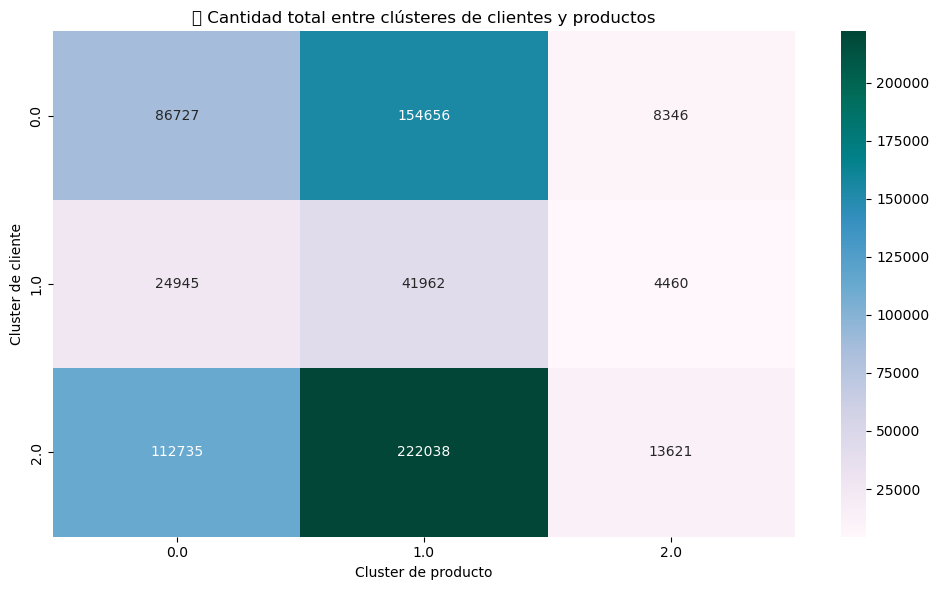

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.heatmap(conexiones_cantidad, annot=True, fmt='.0f', cmap='PuBuGn')

plt.title("📦 Cantidad total entre clústeres de clientes y productos")
plt.xlabel("Cluster de producto")
plt.ylabel("Cluster de cliente")
plt.tight_layout()
plt.show()


# CONCLUSIÓN


Se aplicó K-means para segmentar tanto a los clientes como a los productos, obteniendo tres clústeres por cada grupo. Posteriormente, se cruzaron los clústeres en una matriz para analizar el monto total y la cantidad total de compras. Este análisis se complementó con variables RFM (Recencia, Frecuencia, Monto), evolución temporal de las ventas y comportamiento por país.


## 1. Perfilado de los clusteres de clientes


| Clúster | Recencia | Frecuencia | Monto | Característica principal                                                   |
| ------- | -------- | ---------- | ----- | -------------------------------------------------------------------------- |
| 0       | 49     | 2         |     514| Clientes que no compran seguido, pero mantienen una cierta actividad y gastan un monto decente. Son clientes ocasionales pero activos.                    |
| 1       | 228    | 1       | 387  | Clientes casi perdidos o dormidos. Compraron hace mucho, pocas veces y no gastaron demasiado. Segmento con alto riesgo de abandono total. |
| 2       | 38     | 5      | 1770 | Clientes leales y rentables                    |


## 2. Perfilado de los clusteres de producto

| Cluster | Recency  | Frequency  | Monetary    | Interpretación                                                                 |
|---------|----------|------------|-------------|---------------------------------------------------------------------------------|
| 0       | 7.04     | 307.03     | 496.35      | Productos de buena rotación y valor medio. Estables, funcionales.              |
| 1       | 5.10     | 1491.78    | 1880.92     | Productos estrella: alta demanda, alta frecuencia y alto valor.                |
| 2       | 49.69    | 167.82     | 264.12      | Productos rezagados o de nicho: baja venta reciente, menor valor generado.     |


## 3. Análisis cruzado entre clústeres basado en los mapas de calor

- **Dúo Estrella:**  

  Clientes del clúster **2** (leales y rentables) y productos del clúster **1** (productos estrella) generan el mayor volumen: 

  - Monto total: **26,572**  

  - Cantidad de compras: **222,038**  

- **Segmento Secundario Importante:**  
  Clientes ocasionales (clúster 0) que consumen productos estrella (clúster 1), representando un mercado con potencial de crecimiento.  

- **Clientes de Alto Valor con Productos Estables:**  

  Clientes leales (clúster 2) que consumen productos de rotación media (clúster 0), consolidando ingresos estables.

Estos tres grupos deben ser el foco principal de las estrategias comerciales y de marketing.

## 4. Recomendaciones de marketing Personalizadas 

### Grupo 1

Para Clientes Leales (Clúster 2) y Productos Estrella (Clúster 1)

- Diseñar programas de fidelización con descuentos escalonados.  

- Ofrecer promociones exclusivas para lanzamientos o ediciones limitadas.

- Mantener comunicación frecuente vía email con novedades y recomendaciones personalizadas.


### Grupo 2

Para Clientes Ocasionales (Clúster 0) y Productos Estrella (Clúster 1)

- Implementar promociones tipo 2x1 o muestras gratuitas para incentivar repetición.  

- Realizar campañas de remarketing y envíos de recordatorios.  

- Mejorar la calidad de contenido y reseñas para aumentar la confianza en estos productos.


### Grupo 3

Para Clientes Leales (Clúster 2) y Productos de Rotación Media (Clúster 0)

- Crear paquetes promocionales o bundles atractivos.  


- Promocionar ofertas “comeback” para incentivar la frecuencia de compra.



## 5. Evolucion Temporal

### Análisis Cruzado de Comportamiento Mensual

#### Gasto Promedio Mensual por Clúster de Cliente

- **Clúster 2 (Leales):**  

  Presenta el gasto más alto y creciente, con un pico en noviembre 2011, confirmando su importancia como segmento clave y rentable.

- **Clúster 0 (Ocasionales):**  

  Comienza con gasto moderado y crece a partir de agosto, con picos en octubre y noviembre, posiblemente impulsado por campañas estacionales.

- **Clúster 1 (Dormidos):**  

  Activos hasta julio pero caen abruptamente a partir de agosto, reflejando clientes inactivos o en riesgo de abandono.

#### Ventas Promedio Mensual por Clúster de Producto

- **Clúster 1 (Estrella):**  

  Lidera con crecimiento constante y máximos en noviembre, apuntando a alta demanda y rentabilidad.

- **Clúster 0 (Funcionales):**  

  Mantiene ventas estables durante el año, con un pequeño repunte en otoño, representando productos de apoyo o consumo habitual.

- **Clúster 2 (Rezagados):**  

  Ventas bajas y caída pronunciada en noviembre y diciembre, indicando un segmento en declive o con menor atractivo.

---

###  Recomendaciones General



Enfocar esfuerzos comerciales y campañas de marketing en el binomio más rentable y estratégico:  

**Clientes del Clúster 2 + Productos del Clúster 1**  

Con promociones especiales en los meses con mayor actividad (**septiembre a noviembre**) para maximizar ingresos y fidelización.

---


